<a href="https://colab.research.google.com/github/mahmud-sayed-alamin/GNN-Water-mark/blob/main/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from sklearn.metrics import precision_score, f1_score
import pandas as pd

In [57]:
def load_data():
    dataset = Planetoid(root='/tmp/Cora', name='Cora')
    return dataset[0]

In [58]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.log_softmax(self.conv2(x, edge_index), dim=1)
        return x

In [59]:
def compute_loss(output, y, mask):
    return F.nll_loss(output[mask], y[mask])

def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(data.x, data.edge_index)
    loss = compute_loss(output, data.y, data.train_mask)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        output = model(data.x, data.edge_index)
    predictions = output.argmax(dim=1)
    accuracies = {
        mask_name: (predictions[mask].eq(data.y[mask]).sum().item() / mask.sum().item())
        for mask_name, mask in [('Train', data.train_mask), ('Validation', data.val_mask), ('Test', data.test_mask)]
    }
    return accuracies

In [60]:
def generate_trigger_graph(data, model, num_trigger_nodes=10, target_label=0):
    model.eval()
    with torch.no_grad():
        output = model(data.x, data.edge_index)
    target_nodes = torch.where(output.argmax(dim=1) == target_label)[0][:num_trigger_nodes]
    trigger_features = data.x[target_nodes].clone()
    num_original_nodes = data.x.shape[0]
    trigger_indices = torch.arange(num_original_nodes, num_original_nodes + num_trigger_nodes)
    new_edges = torch.cat([
        torch.stack([trigger_indices, target_nodes], dim=0),
        torch.stack([target_nodes, trigger_indices], dim=0)
    ], dim=1)
    return {'features': trigger_features, 'edges': new_edges, 'nodes': trigger_indices}

def verify_ownership(model, data, trigger_graph, target_label):
    model.eval()
    x_combined = torch.cat([data.x, trigger_graph['features']], dim=0)
    edge_index_combined = torch.cat([data.edge_index, trigger_graph['edges']], dim=1)
    with torch.no_grad():
        output = model(x_combined, edge_index_combined)
    predictions = output[trigger_graph['nodes']].argmax(dim=1)
    return (predictions == target_label).sum().item() / len(trigger_graph['nodes'])

In [61]:
def calculate_metrics(model, data):
    output = model(data.x, data.edge_index)
    pred = output.argmax(dim=1)
    y_true = data.y[data.test_mask].cpu().numpy()
    y_pred = pred[data.test_mask].cpu().numpy()
    return {
        'Precision': precision_score(y_true, y_pred, average='weighted') * 100,
        'F1-Score': f1_score(y_true, y_pred, average='weighted') * 100
    }

data = load_data()
model = GCN(in_channels=1433, hidden_channels=128, out_channels=7)
optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-2)

In [62]:
# Training loop
for epoch in range(200):
    loss = train(model, data, optimizer)
    if epoch % 10 == 0:
        accs = evaluate(model, data)
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Train Acc: {accs['Train']:.4f}, Val Acc: {accs['Validation']:.4f}, Test Acc: {accs['Test']:.4f}")

# Watermarking process
trigger_graph = generate_trigger_graph(data, model)
trigger_accuracy = verify_ownership(model, data, trigger_graph, target_label=0)
print(f"Watermark Accuracy: {trigger_accuracy * 100:.2f}%")

# Compute metrics
metrics = calculate_metrics(model, data)
print(f"Precision: {metrics['Precision']:.2f}%\nF1-Score: {metrics['F1-Score']:.2f}%")

Epoch 000, Loss: 1.9532, Train Acc: 0.7929, Val Acc: 0.5140, Test Acc: 0.5220
Epoch 010, Loss: 0.9134, Train Acc: 0.9714, Val Acc: 0.7720, Test Acc: 0.8050
Epoch 020, Loss: 0.6712, Train Acc: 0.9857, Val Acc: 0.7820, Test Acc: 0.8150
Epoch 030, Loss: 0.6937, Train Acc: 0.9857, Val Acc: 0.7900, Test Acc: 0.8130
Epoch 040, Loss: 0.7433, Train Acc: 0.9786, Val Acc: 0.7820, Test Acc: 0.8080
Epoch 050, Loss: 0.7315, Train Acc: 0.9857, Val Acc: 0.7820, Test Acc: 0.8090
Epoch 060, Loss: 0.7212, Train Acc: 0.9857, Val Acc: 0.7820, Test Acc: 0.8120
Epoch 070, Loss: 0.7262, Train Acc: 0.9857, Val Acc: 0.7820, Test Acc: 0.8110
Epoch 080, Loss: 0.7225, Train Acc: 0.9857, Val Acc: 0.7820, Test Acc: 0.8120
Epoch 090, Loss: 0.7227, Train Acc: 0.9857, Val Acc: 0.7820, Test Acc: 0.8110
Epoch 100, Loss: 0.7217, Train Acc: 0.9786, Val Acc: 0.7820, Test Acc: 0.8120
Epoch 110, Loss: 0.7207, Train Acc: 0.9857, Val Acc: 0.7840, Test Acc: 0.8100
Epoch 120, Loss: 0.7202, Train Acc: 0.9857, Val Acc: 0.7840, Tes

In [63]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to evaluate model performance
def evaluate_model(model, data):
    output = model(data.x, data.edge_index)
    pred = output.argmax(dim=1)

    y_true = data.y[data.test_mask].cpu().numpy()
    y_pred = pred[data.test_mask].cpu().numpy()

    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, average='weighted') * 100
    recall = recall_score(y_true, y_pred, average='weighted') * 100
    f1 = f1_score(y_true, y_pred, average='weighted') * 100

    return accuracy, precision, recall, f1

# Evaluate the original model
model_accuracy_original, model_precision_original, model_recall_original, model_f1_original = evaluate_model(model, data)

# Evaluate the watermarked model
model_accuracy_watermarked, model_precision_watermarked, model_recall_watermarked, model_f1_watermarked = evaluate_model(model, new_data)

# Paper results for GCN on Cora
paper_results = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Paper Original": [83.74, 83.84, 80.69, 83.70],
    "Paper Watermarked": [83.40, 83.47, 80.19, 83.70],
}

results = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Original": [model_accuracy_original, model_precision_original, model_recall_original, model_f1_original],
    "Watermarked": [model_accuracy_watermarked, model_precision_watermarked, model_recall_watermarked, model_f1_watermarked],
}

comparison_df = pd.DataFrame(paper_results).set_index("Metric")
comparison_df[["Original", "Watermarked"]] = pd.DataFrame(results).set_index("Metric")

print("\nComparison Table (GCN on Cora)\n")
print(comparison_df.to_markdown())




Comparison Table (GCN on Cora)

| Metric    |   Paper Original |   Paper Watermarked |   Original |   Watermarked |
|:----------|-----------------:|--------------------:|-----------:|--------------:|
| Accuracy  |            83.74 |               83.4  |    81.2    |       81.2    |
| Precision |            83.84 |               83.47 |    83.0001 |       83.0001 |
| Recall    |            80.69 |               80.19 |    81.2    |       81.2    |
| F1-Score  |            83.7  |               83.7  |    81.4236 |       81.4236 |


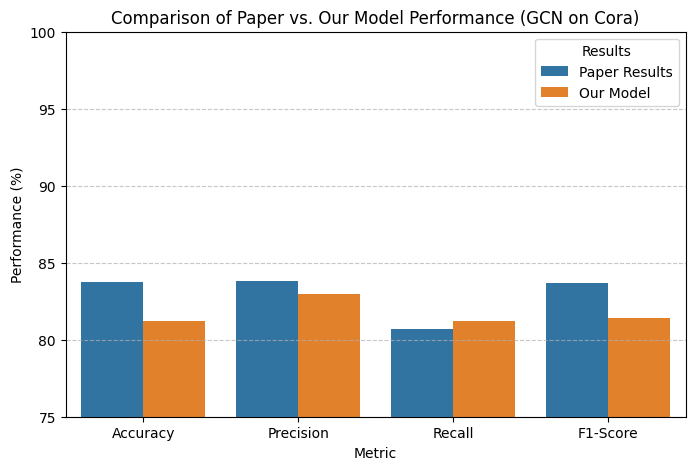

In [64]:
# Visualization
plt.figure(figsize=(8, 5))
df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Paper Results": [83.74, 83.84, 80.69, 83.70],
    "Our Model": [model_accuracy_original, model_precision_original, model_recall_original, model_f1_original]
})

ax = sns.barplot(x="Metric", y="value", hue="variable", data=df.melt(id_vars=["Metric"], var_name="variable"))
plt.xlabel("Metric")
plt.ylabel("Performance (%)")
plt.title("Comparison of Paper vs. Our Model Performance (GCN on Cora)")
plt.ylim(75, 100)
plt.legend(title="Results")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()